# Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')


# Data

## Intake data

In [2]:
intake_url = "https://data.austintexas.gov/resource/wter-evkm.csv?$limit=500000"

In [3]:
df_intakes = pd.read_csv(intake_url)

## Outcome data

In [4]:
outcome_url = "https://data.austintexas.gov/resource/9t4d-g238.csv?$limit=500000"

In [5]:
df_outcomes = pd.read_csv(outcome_url)

# EDA

## Intake data

In [6]:
df_intakes.head()

,animal_id,name,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color
0,A521520,Nina,2013-10-01T07:51:00.000,2013-10-01T07:51:00.000,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan
1,A664235,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2,A664236,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
3,A664237,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
4,A664233,Stevie,2013-10-01T08:53:00.000,2013-10-01T08:53:00.000,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White


In [7]:
print(df_intakes['intake_type'].unique())

['Stray' 'Owner Surrender' 'Public Assist' 'Euthanasia Request' 'Wildlife'
 'Abandoned']


In [8]:
print(df_intakes['sex_upon_intake'].value_counts())

sex_upon_intake
Intact Male      58996
Intact Female    56714
Neutered Male    24236
Spayed Female    20324
Unknown          13541
Name: count, dtype: int64


In [9]:
#missing values by column
df_intakes.isnull().sum()

animal_id               0
name                49991
datetime                0
datetime2               0
found_location          0
intake_type             0
intake_condition        0
animal_type             0
sex_upon_intake         1
age_upon_intake         0
breed                   0
color                   0
dtype: int64

In [10]:
print(df_intakes['age_upon_intake'].value_counts())

age_upon_intake
1 year       28294
2 years      28033
1 month      18203
2 months     10432
3 years       9610
4 weeks       6324
4 years       5842
5 years       5187
3 weeks       5124
3 months      4924
4 months      4787
5 months      4377
2 weeks       3655
6 years       3426
6 months      3329
7 years       3010
8 years       2834
7 months      2591
9 months      2496
10 years      2292
8 months      2027
9 years       1673
1 week        1483
1 weeks       1433
10 months     1388
0 years       1268
11 months     1140
12 years      1116
1 day         1018
11 years       925
3 days         920
2 days         771
13 years       717
6 days         538
14 years       525
4 days         501
15 years       453
5 weeks        444
5 days         265
16 years       193
17 years       104
18 years        62
19 years        29
20 years        26
22 years         6
-1 years         6
25 years         2
-3 years         2
-2 years         1
24 years         1
-4 years         1
21 years       

In [11]:
# Only keep Dog and Cat in animal_type
df_intakes = df_intakes[df_intakes['animal_type'].isin(['Dog', 'Cat'])]

In [12]:
print(df_intakes['intake_type'].value_counts())

intake_type
Stray                 117484
Owner Surrender        34475
Public Assist           9866
Abandoned               1863
Euthanasia Request       243
Wildlife                   1
Name: count, dtype: int64


In [13]:
df_intakes = df_intakes[df_intakes['intake_type'].isin(['Stray', 'Owner Surrender','Public Assist','Abandoned','Euthanasia Request'])]

In [14]:
# Extract monthyear from datetime column
df_intakes['datetime'] = pd.to_datetime(df_intakes['datetime'])
df_intakes['monthyear'] = df_intakes['datetime'].dt.to_period('M').astype(str)

# Group and count intakes
aggregated_intakes = (df_intakes.groupby(['animal_type', 'intake_type', 'monthyear'])
                               .size()
                               .reset_index(name='count'))

# Rename and reorder columns
aggregated_intakes = aggregated_intakes.rename(columns={'monthyear': 'date'})
aggregated_intakes = aggregated_intakes[['count', 'date', 'animal_type', 'intake_type']]

# Sort by date, then animal type
aggregated_intakes = aggregated_intakes.sort_values(['date', 'animal_type']).reset_index(drop=True)

In [15]:
aggregated_intakes.head(20)

,count,date,animal_type,intake_type
0,3,2013-10,Cat,Euthanasia Request
1,117,2013-10,Cat,Owner Surrender
2,3,2013-10,Cat,Public Assist
3,419,2013-10,Cat,Stray
4,9,2013-10,Dog,Euthanasia Request
5,174,2013-10,Dog,Owner Surrender
6,66,2013-10,Dog,Public Assist
7,716,2013-10,Dog,Stray
8,5,2013-11,Cat,Euthanasia Request
9,101,2013-11,Cat,Owner Surrender


In [16]:
aggregated_intakes['date'].nunique()

140

## Outcome data

In [17]:
df_outcomes.head()

,animal_id,date_of_birth,name,datetime,monthyear,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A668305,2012-12-01,NaN,2013-12-02T00:00:00-05:00,12-2013,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Brown/Yellow
1,A673335,2012-02-22,NaN,2014-02-22T00:00:00-05:00,02-2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon,Black/Gray
2,A675999,2013-04-03,NaN,2014-04-07T00:00:00-05:00,04-2014,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Green
3,A679066,2014-04-16,NaN,2014-05-16T00:00:00-05:00,05-2014,NaN,NaN,Other,Unknown,4 weeks,Rabbit Sh,Brown
4,A680855,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black


In [18]:
print(df_outcomes['outcome_type'].unique())

# Value counts for outcome_type
print(df_outcomes['outcome_type'].value_counts())

['Transfer' 'Euthanasia' nan 'Adoption' 'Return to Owner' 'Died' 'Missing'
 'Disposal' 'Relocate' 'Rto-Adopt' 'Stolen' 'Lost']
outcome_type
Adoption           84598
Transfer           48689
Return to Owner    25691
Euthanasia         10833
Died                1672
Rto-Adopt           1241
Disposal             877
Missing               92
Relocate              29
Stolen                 5
Lost                   2
Name: count, dtype: int64


In [19]:
print(df_outcomes['sex_upon_outcome'].value_counts())

sex_upon_outcome
Neutered Male    60933
Spayed Female    55269
Intact Male      22263
Intact Female    21804
Unknown          13505
Name: count, dtype: int64


In [20]:
breed_df = df_outcomes['breed'].value_counts()
breed_df.head(20)

breed
Domestic Shorthair Mix       34039
Domestic Shorthair           23842
Pit Bull Mix                 10151
Labrador Retriever Mix        8812
Chihuahua Shorthair Mix       6920
German Shepherd Mix           4053
Pit Bull                      3407
Domestic Medium Hair Mix      3377
Bat                           2356
Domestic Medium Hair          2103
Labrador Retriever            2029
Chihuahua Shorthair           2009
Australian Cattle Dog Mix     1991
German Shepherd               1826
Bat Mix                       1756
Domestic Longhair Mix         1687
Siamese Mix                   1475
Dachshund Mix                 1191
Boxer Mix                     1185
Border Collie Mix             1150
Name: count, dtype: int64

In [21]:
print(df_outcomes['breed'].nunique())

3010


In [22]:
df_outcomes = df_outcomes[df_outcomes['animal_type'].isin(['Dog', 'Cat'])]

In [23]:
df_outcomes = df_outcomes[df_outcomes['outcome_type'].isin(['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Died','Rto-Adopt'])]

In [24]:
# Clean column names
df_outcomes.columns = df_outcomes.columns.str.strip()

# Handle different column name formats
df_outcomes_ts = df_outcomes.rename(columns={
    'Animal Type': 'animal_type',
    'Outcome Type': 'outcome_type', 
    'MonthYear': 'monthyear'
})

# Group and count
aggregated_df_outcomes = (df_outcomes_ts.groupby(['animal_type', 'outcome_type', 'monthyear'])
                  .size()
                  .reset_index(name='count'))

# Rename and reorder columns
aggregated_df_outcomes = aggregated_df_outcomes.rename(columns={'monthyear': 'date'})
aggregated_df_outcomes = aggregated_df_outcomes[['count', 'animal_type', 'outcome_type', 'date']]

# Sort by date, then animal type
aggregated_df_outcomes = aggregated_df_outcomes.sort_values(['date', 'animal_type']).reset_index(drop=True)

In [25]:
aggregated_df_outcomes.head(20)

,count,animal_type,outcome_type,date
0,159,Cat,Adoption,01-2014
1,1,Cat,Died,01-2014
2,23,Cat,Euthanasia,01-2014
3,38,Cat,Return to Owner,01-2014
4,146,Cat,Transfer,01-2014
5,359,Dog,Adoption,01-2014
6,3,Dog,Died,01-2014
7,45,Dog,Euthanasia,01-2014
8,248,Dog,Return to Owner,01-2014
9,204,Dog,Transfer,01-2014


# Plots

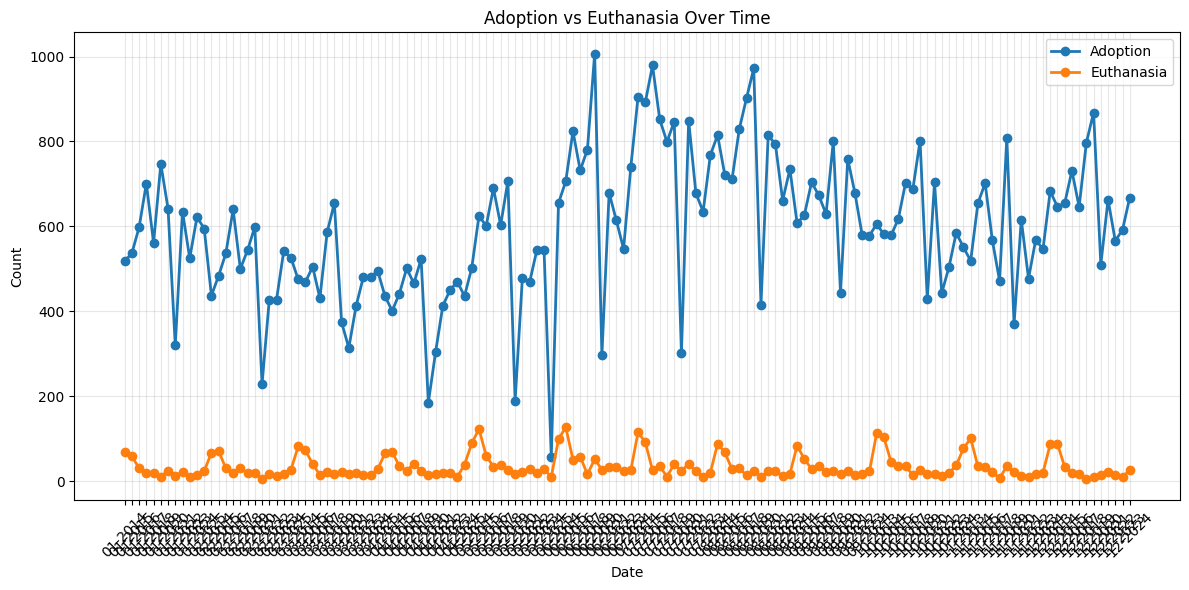

In [26]:
# Filter for Adoption and Euthanasia outcomes
filtered_df = aggregated_df_outcomes[aggregated_df_outcomes['outcome_type'].isin(['Adoption', 'Euthanasia'])]

# Aggregate by month and outcome_type
monthly_outcomes = (filtered_df.groupby(['date', 'outcome_type'])['count']
                              .sum()
                              .reset_index())

# Pivot for plotting
pivot_df = monthly_outcomes.pivot(index='date', columns='outcome_type', values='count')
pivot_df = pivot_df.fillna(0)

# Create line chart
plt.figure(figsize=(12, 6))
for outcome in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[outcome], marker='o', label=outcome, linewidth=2)

plt.title('Adoption vs Euthanasia Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

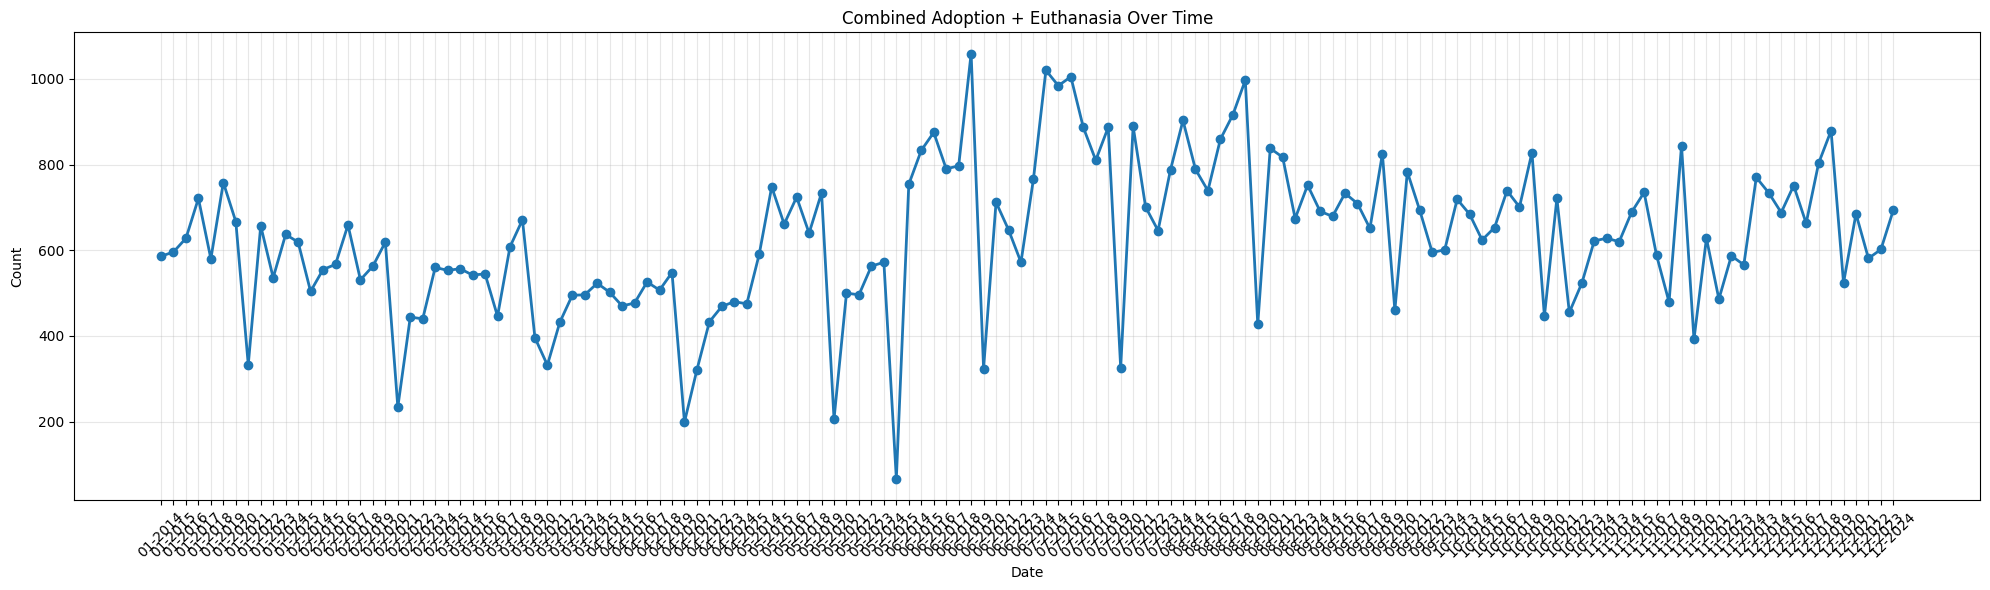

In [27]:
# Filter for Adoption and Euthanasia outcomes
filtered_df = aggregated_df_outcomes[aggregated_df_outcomes['outcome_type'].isin(['Adoption', 'Euthanasia'])]

# Aggregate by month (sum both outcome types)
monthly_total = (filtered_df.groupby('date')['count']
                           .sum()
                           .reset_index())

# Create line chart
plt.figure(figsize=(20, 6))
plt.plot(monthly_total['date'], monthly_total['count'], marker='o', linewidth=2)

plt.title('Combined Adoption + Euthanasia Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

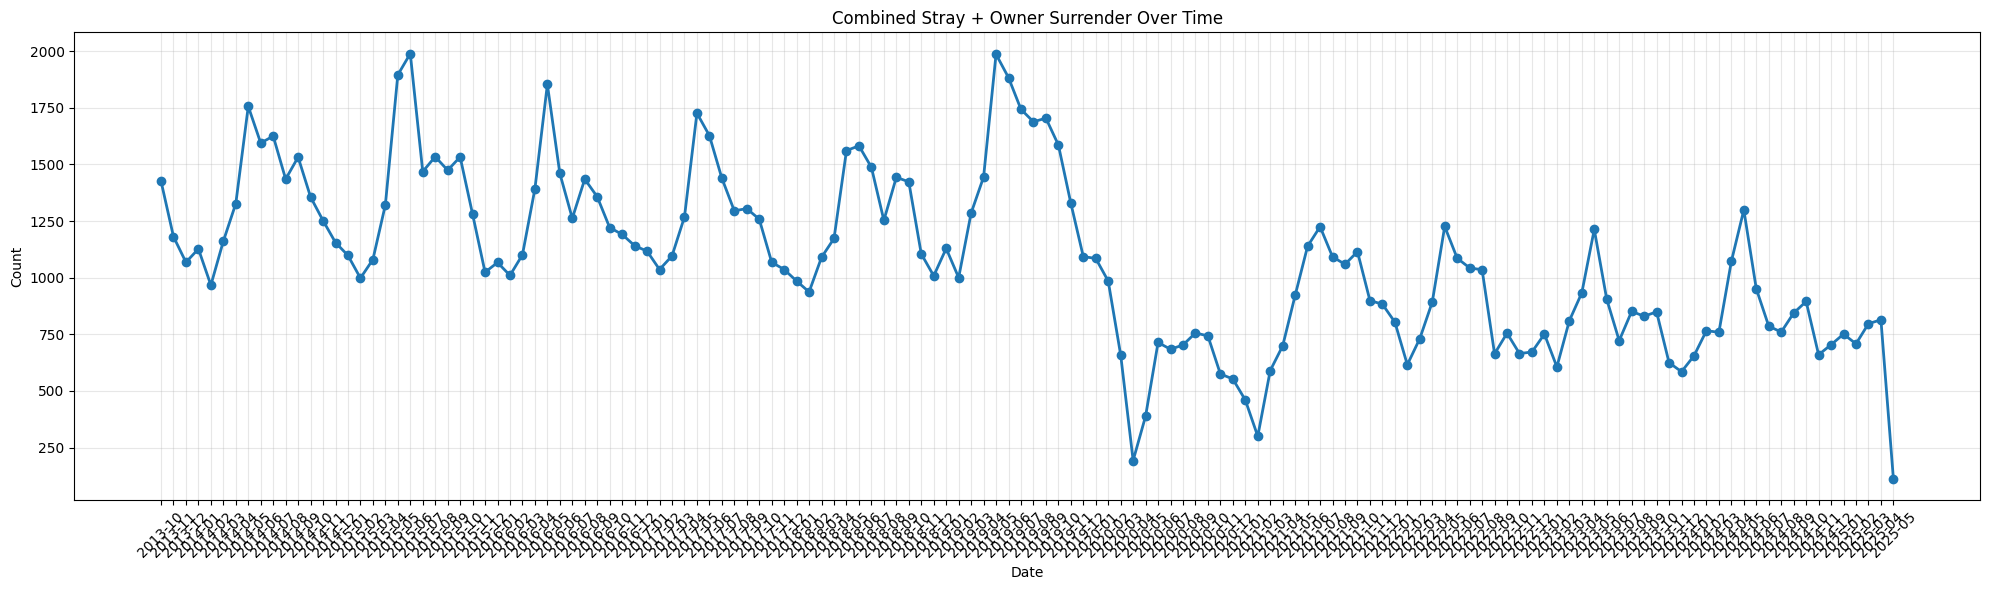

In [28]:
# Filter for Adoption and Euthanasia outcomes
filtered_df = aggregated_intakes[aggregated_intakes['intake_type'].isin(['Stray', 'Owner Surrender'])]

# Aggregate by month (sum both outcome types)
monthly_total = (filtered_df.groupby('date')['count']
                           .sum()
                           .reset_index())

# Create line chart
plt.figure(figsize=(20, 6))
plt.plot(monthly_total['date'], monthly_total['count'], marker='o', linewidth=2)

plt.title('Combined Stray + Owner Surrender Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Preprocessing

In [151]:
def create_lag_features(df, target_col, lags=[1, 2, 3, 6, 12]):
    """
    Create lag features for time series data
    
    Parameters:
    df: DataFrame with datetime index and target column
    target_col: column name to create lags for
    lags: list of lag periods (in months)
    """
    df = df.copy()
    
    # Create lag features
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    return df

def create_rolling_features(df, target_col, windows=[3, 6, 12]):
    """
    Create rolling window features
    
    Parameters:
    df: DataFrame with datetime index and target column
    target_col: column name to create rolling features for
    windows: list of window sizes (in months)
    """
    df = df.copy()
    
    for window in windows:
        # Rolling mean
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        
        # Rolling std
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        
        # Rolling min/max
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
    
    return df

def create_seasonal_features(df, date_col):
    """
    Create basic seasonal features from date
    
    Parameters:
    df: DataFrame 
    date_col: name of date column or datetime index
    """
    df = df.copy()
    
    if date_col in df.columns:
        dates = pd.to_datetime(df[date_col])
    else:
        dates = df.index
    
    # Extract month and create cyclical features
    df['month'] = pd.to_datetime(df[date_col]).dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Year-over-year comparison
    df['year'] = pd.to_datetime(df[date_col]).dt.year
    
    return df

def create_ratio_features(df, intake_col, outcome_col):
    """
    Create ratio and interaction features between intake and outcome
    
    Parameters:
    df: DataFrame
    intake_col: intake column name
    outcome_col: outcome column name
    """
    df = df.copy()
    
    # Current month ratio
    df['intake_outcome_ratio'] = df[intake_col] / (df[outcome_col] + 1)  # +1 to avoid division by zero
    
    # Cumulative difference (net flow)
    df['net_flow'] = df[intake_col] - df[outcome_col]
    df['cumulative_net_flow'] = df['net_flow'].cumsum()
    
    # Rate of change
    df[f'{intake_col}_pct_change'] = df[intake_col].pct_change()
    df[f'{outcome_col}_pct_change'] = df[outcome_col].pct_change()
    
    return df

def prepare_intake_features(df, intake_col='intake_count', date_col='date'):
    """
    Prepare features for intake prediction
    """
    df = df.copy()
    
    # Create seasonal features
    df = create_seasonal_features(df, date_col)
    
    # Create lag features
    df = create_lag_features(df, intake_col, lags=[1, 2, 3, 6, 12])
    
    # Create rolling features
    df = create_rolling_features(df, intake_col, windows=[3, 6, 12])
    
    # Year-over-year comparison
    df[f'{intake_col}_yoy'] = df[intake_col] / df[intake_col].shift(12)
    
    return df

def prepare_outcome_features(df, intake_col='intake_count', outcome_col='outcome_count', date_col='date'):
    """
    Prepare features for outcome prediction
    """
    df = df.copy()
    
    # Create seasonal features
    df = create_seasonal_features(df, date_col)
    
    # Create lag features for both intake and outcome
    df = create_lag_features(df, intake_col, lags=[1, 2, 3, 6])
    df = create_lag_features(df, outcome_col, lags=[1, 2, 3, 6])
    
    # Create rolling features
    df = create_rolling_features(df, intake_col, windows=[3, 6])
    df = create_rolling_features(df, outcome_col, windows=[3, 6])
    
    # Create ratio and interaction features
    df = create_ratio_features(df, intake_col, outcome_col)
    
    return df

In [152]:
# Filter data first  
aggregated_intakes_filtered = aggregated_intakes[
    (aggregated_intakes['animal_type'].isin(['Dog', 'Cat'])) & 
    (aggregated_intakes['intake_type'].isin(['Stray', 'Owner Surrender']))
].copy()

aggregated_df_outcomes_filtered = aggregated_df_outcomes[
    (aggregated_df_outcomes['animal_type'].isin(['Dog', 'Cat'])) & 
    (aggregated_df_outcomes['outcome_type'] == 'Adoption')
].copy()

# Aggregate by date for each dataset
intake_agg = aggregated_intakes_filtered.groupby('date')['count'].sum().reset_index()
outcome_agg = aggregated_df_outcomes_filtered.groupby('date')['count'].sum().reset_index()

# For intake prediction
df_intake_features = prepare_intake_features(intake_agg, intake_col='count', date_col='date')

# For outcome prediction - use outcome data directly
df_outcome_features = prepare_intake_features(outcome_agg, intake_col='count', date_col='date')

In [153]:
df_intake_clean = df_intake_features.dropna()
df_outcome_clean = df_outcome_features.dropna()

# Time series models

## Intake model

Here, the choice of models are XGBoost and Facebook's Prophet

In [54]:
class IntakeXGBoostModel:
    def __init__(self):
        self.model = xgb.XGBRegressor(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.05,
            reg_alpha=1.0,
            reg_lambda=1.0,
            random_state=42
        )
        self.feature_cols = None
        
    def prepare_features(self, df):
        # Select feature columns (exclude target and date)
        exclude_cols = ['count', 'date', 'year']
        self.feature_cols = [col for col in df.columns if col not in exclude_cols]
        return df[self.feature_cols]
    
    def fit(self, df):
        X = self.prepare_features(df)
        y = df['count']
        self.model.fit(X, y)
        return self
    
    def predict(self, df):
        X = df[self.feature_cols]
        return self.model.predict(X)
    
    def get_feature_importance(self):
        importance_df = pd.DataFrame({
            'feature': self.feature_cols,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        return importance_df

class IntakeProphetModel:
    def __init__(self):
        self.model = None
        
    def prepare_data(self, df):
        # Prophet requires 'ds' and 'y' columns
        prophet_df = pd.DataFrame({
            'ds': pd.to_datetime(df['date']),
            'y': df['count']
        })
        return prophet_df
    
    def fit(self, df):
        train_data = self.prepare_data(df)
        self.model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,  # Monthly data doesn't need weekly
            daily_seasonality=False,
            seasonality_mode='multiplicative'
        )
        self.model.fit(train_data)
        return self
    
    def predict(self, periods=12):
        # Create future dataframe
        future = self.model.make_future_dataframe(periods=periods, freq='M')
        forecast = self.model.predict(future)
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


## Outcome model

Here, the choice of models are XGBoost and SARIMA

In [61]:
class OutcomeXGBoostModel:
    def __init__(self):
        self.model = xgb.XGBRegressor(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.05,
            reg_alpha=1.0,
            reg_lambda=1.0,
            random_state=42
        )
        self.feature_cols = None
        
    def prepare_features(self, df):
        # Select feature columns (exclude target and date)
        exclude_cols = ['count', 'date', 'year']
        self.feature_cols = [col for col in df.columns if col not in exclude_cols]
        return df[self.feature_cols]
    
    def fit(self, df):
        X = self.prepare_features(df)
        y = df['count']
        self.model.fit(X, y)
        return self
    
    def predict(self, df):
        X = df[self.feature_cols]
        return self.model.predict(X)
    
    def get_feature_importance(self):
        importance_df = pd.DataFrame({
            'feature': self.feature_cols,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        return importance_df

class OutcomeSARIMAModel:
    def __init__(self):
        self.model = None
        self.fitted_model = None
        
    def find_best_order(self, ts, max_p=3, max_d=2, max_q=3):
        """Find best SARIMA parameters using AIC"""
        best_aic = float('inf')
        best_order = None
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(ts, order=(p, d, q), seasonal_order=(1, 1, 1, 12))
                        fitted = model.fit()
                        if fitted.aic < best_aic:
                            best_aic = fitted.aic
                            best_order = (p, d, q)
                    except:
                        continue
        
        return best_order if best_order else (1, 1, 1)
    
    def fit(self, df):
        ts = df.set_index('date')['count']
        
        # Find best parameters
        best_order = self.find_best_order(ts)
        
        # Fit SARIMA model
        self.model = ARIMA(ts, order=best_order, seasonal_order=(1, 1, 1, 12))
        self.fitted_model = self.model.fit()
        return self
    
    def predict(self, periods=12):
        forecast = self.fitted_model.forecast(steps=periods)
        conf_int = self.fitted_model.get_forecast(steps=periods).conf_int()
        
        return {
            'forecast': forecast,
            'conf_lower': conf_int.iloc[:, 0],
            'conf_upper': conf_int.iloc[:, 1]
        }

## Model evaluation

In [62]:
def evaluate_model(y_true, y_pred):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

def time_series_cv(model, df, target_col, n_splits=5):
    """Time series cross-validation"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_idx, test_idx in tscv.split(df):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        
        model.fit(train_df)
        predictions = model.predict(test_df)
        score = mean_squared_error(test_df[target_col], predictions)
        scores.append(score)
    
    return np.mean(scores), np.std(scores)

## Intake run

In [59]:
print("Training Intake Models...")

# XGBoost for Intakes
intake_xgb = IntakeXGBoostModel()
intake_xgb.fit(df_intake_clean)
intake_xgb_pred = intake_xgb.predict(df_intake_clean)
print("Intake XGBoost Metrics:", evaluate_model(df_intake_clean['count'], intake_xgb_pred))
print("Feature Importance:\n", intake_xgb.get_feature_importance().head(10))

# Prophet for Intakes
intake_prophet = IntakeProphetModel()
intake_prophet.fit(df_intake_clean)
intake_prophet_forecast = intake_prophet.predict(periods=12)
print("Intake Prophet forecast completed")

12:42:03 - cmdstanpy - INFO - Chain [1] start processing


Training Intake Models...
Intake XGBoost Metrics: {'MSE': 4831.55419921875, 'MAE': 53.570167541503906, 'RMSE': np.float64(69.50938209492838), 'R2': 0.9646112322807312, 'MAPE': 0.07681278139352798}
Feature Importance:
                  feature  importance
8   count_rolling_mean_3    0.387769
11   count_rolling_max_3    0.118262
17  count_rolling_std_12    0.080832
14   count_rolling_min_6    0.075249
10   count_rolling_min_3    0.069659
15   count_rolling_max_6    0.043336
7           count_lag_12    0.042752
2              month_cos    0.030321
0                  month    0.027124
5            count_lag_3    0.024683


12:42:03 - cmdstanpy - INFO - Chain [1] done processing


Intake Prophet forecast completed


## Outcome run

In [63]:
print("\nTraining Outcome Models...")

# XGBoost for Outcomes
outcome_xgb = OutcomeXGBoostModel()
outcome_xgb.fit(df_outcome_clean)
outcome_xgb_pred = outcome_xgb.predict(df_outcome_clean)
print("Outcome XGBoost Metrics:", evaluate_model(df_outcome_clean['count'], outcome_xgb_pred))
print("Feature Importance:\n", outcome_xgb.get_feature_importance().head(10))

# SARIMA for Outcomes
outcome_sarima = OutcomeSARIMAModel()
outcome_sarima.fit(df_outcome_clean)
outcome_sarima_forecast = outcome_sarima.predict(periods=12)
print("Outcome SARIMA forecast completed")


Training Outcome Models...
Outcome XGBoost Metrics: {'MSE': 2302.494140625, 'MAE': 35.41178894042969, 'RMSE': np.float64(47.98431140096729), 'R2': 0.9202534556388855, 'MAPE': 0.0888349860906601}
Feature Importance:
                  feature  importance
8   count_rolling_mean_3    0.356757
12  count_rolling_mean_6    0.075420
7           count_lag_12    0.067474
10   count_rolling_min_3    0.063989
20             count_yoy    0.061473
3            count_lag_1    0.060562
11   count_rolling_max_3    0.059976
9    count_rolling_std_3    0.047784
14   count_rolling_min_6    0.040450
2              month_cos    0.025998
Outcome SARIMA forecast completed


In [64]:
class ProphetEvaluator:
    def __init__(self):
        self.model = None
        self.train_data = None
        self.test_data = None
        self.forecast = None
        
    def prepare_data(self, df, train_size=0.8):
        """Split data and prepare for Prophet"""
        # Convert to Prophet format
        prophet_df = pd.DataFrame({
            'ds': pd.to_datetime(df['date']),
            'y': df['count']
        })
        
        # Split train/test
        split_idx = int(len(prophet_df) * train_size)
        self.train_data = prophet_df[:split_idx]
        self.test_data = prophet_df[split_idx:]
        
        return self.train_data, self.test_data
    
    def fit_and_forecast(self):
        """Fit Prophet model and generate forecast"""
        self.model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative'
        )
        self.model.fit(self.train_data)
        
        # Create future dataframe for test period
        future = self.model.make_future_dataframe(periods=len(self.test_data), freq='M')
        self.forecast = self.model.predict(future)
        
        return self.forecast
    
    def evaluate(self):
        """Calculate evaluation metrics"""
        # Get predictions for test period
        test_predictions = self.forecast.tail(len(self.test_data))['yhat'].values
        actual = self.test_data['y'].values
        
        metrics = {
            'MAE': mean_absolute_error(actual, test_predictions),
            'MSE': mean_squared_error(actual, test_predictions),
            'RMSE': np.sqrt(mean_squared_error(actual, test_predictions)),
            'R2': r2_score(actual, test_predictions),
            'MAPE': np.mean(np.abs((actual - test_predictions) / actual)) * 100
        }
        
        return metrics, test_predictions
    
    def plot_components(self):
        """Plot Prophet components"""
        if self.model and self.forecast is not None:
            fig = self.model.plot_components(self.forecast)
            plt.tight_layout()
            plt.show()
    
    def plot_forecast(self):
        """Plot forecast vs actual"""
        if self.forecast is not None:
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Plot training data
            ax.plot(self.train_data['ds'], self.train_data['y'], 'b-', label='Training')
            
            # Plot test data
            ax.plot(self.test_data['ds'], self.test_data['y'], 'g-', label='Actual Test')
            
            # Plot forecast
            test_forecast = self.forecast.tail(len(self.test_data))
            ax.plot(test_forecast['ds'], test_forecast['yhat'], 'r--', label='Forecast')
            ax.fill_between(test_forecast['ds'], 
                          test_forecast['yhat_lower'], 
                          test_forecast['yhat_upper'], 
                          alpha=0.3, color='red')
            
            ax.legend()
            ax.set_title('Prophet Forecast vs Actual')
            plt.tight_layout()
            plt.show()

class SARIMAEvaluator:
    def __init__(self):
        self.model = None
        self.fitted_model = None
        self.train_data = None
        self.test_data = None
        self.best_order = None
        
    def prepare_data(self, df, train_size=0.8):
        """Split data for SARIMA"""
        ts = df.set_index('date')['count']
        split_idx = int(len(ts) * train_size)
        
        self.train_data = ts[:split_idx]
        self.test_data = ts[split_idx:]
        
        return self.train_data, self.test_data
    
    def check_stationarity(self, ts):
        """Check if series is stationary"""
        result = adfuller(ts.dropna())
        return {
            'ADF_Statistic': result[0],
            'p_value': result[1],
            'Critical_Values': result[4],
            'is_stationary': result[1] < 0.05
        }
    
    def find_best_order(self, max_p=3, max_d=2, max_q=3):
        """Find best SARIMA parameters using AIC"""
        best_aic = float('inf')
        best_order = None
        best_seasonal = None
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    for P in [0, 1]:
                        for D in [0, 1]:
                            for Q in [0, 1]:
                                try:
                                    model = ARIMA(self.train_data, 
                                                order=(p, d, q), 
                                                seasonal_order=(P, D, Q, 12))
                                    fitted = model.fit()
                                    if fitted.aic < best_aic:
                                        best_aic = fitted.aic
                                        best_order = (p, d, q)
                                        best_seasonal = (P, D, Q, 12)
                                except:
                                    continue
        
        self.best_order = best_order
        self.best_seasonal = best_seasonal
        return best_order, best_seasonal, best_aic
    
    def fit_and_forecast(self, order=None, seasonal_order=None):
        """Fit SARIMA model and generate forecast"""
        if order is None:
            order, seasonal_order, _ = self.find_best_order()
        
        self.model = ARIMA(self.train_data, order=order, seasonal_order=seasonal_order)
        self.fitted_model = self.model.fit()
        
        # Forecast
        forecast_steps = len(self.test_data)
        forecast = self.fitted_model.forecast(steps=forecast_steps)
        conf_int = self.fitted_model.get_forecast(steps=forecast_steps).conf_int()
        
        return forecast, conf_int
    
    def evaluate(self, forecast):
        """Calculate evaluation metrics"""
        actual = self.test_data.values
        predicted = forecast.values
        
        metrics = {
            'MAE': mean_absolute_error(actual, predicted),
            'MSE': mean_squared_error(actual, predicted),
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'R2': r2_score(actual, predicted),
            'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100,
            'AIC': self.fitted_model.aic,
            'BIC': self.fitted_model.bic
        }
        
        return metrics
    
    def diagnostic_plots(self):
        """Generate diagnostic plots"""
        if self.fitted_model:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Residuals
            residuals = self.fitted_model.resid
            
            # 1. Residuals plot
            axes[0,0].plot(residuals)
            axes[0,0].set_title('Residuals')
            axes[0,0].grid(True)
            
            # 2. ACF of residuals
            plot_acf(residuals.dropna(), ax=axes[0,1], lags=20)
            axes[0,1].set_title('ACF of Residuals')
            
            # 3. PACF of residuals
            plot_pacf(residuals.dropna(), ax=axes[1,0], lags=20)
            axes[1,0].set_title('PACF of Residuals')
            
            # 4. Q-Q plot
            from scipy import stats
            stats.probplot(residuals.dropna(), dist="norm", plot=axes[1,1])
            axes[1,1].set_title('Q-Q Plot')
            
            plt.tight_layout()
            plt.show()
    
    def ljung_box_test(self):
        """Ljung-Box test for residual autocorrelation"""
        if self.fitted_model:
            residuals = self.fitted_model.resid.dropna()
            lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=False)
            return {
                'Ljung_Box_Stat': lb_stat[-1],
                'p_value': lb_pvalue[-1],
                'residuals_independent': lb_pvalue[-1] > 0.05
            }
    
    def plot_forecast(self, forecast, conf_int):
        """Plot forecast vs actual"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot training data
        ax.plot(self.train_data.index, self.train_data.values, 'b-', label='Training')
        
        # Plot test data
        ax.plot(self.test_data.index, self.test_data.values, 'g-', label='Actual Test')
        
        # Plot forecast
        ax.plot(self.test_data.index, forecast.values, 'r--', label='Forecast')
        ax.fill_between(self.test_data.index, 
                       conf_int.iloc[:, 0], 
                       conf_int.iloc[:, 1], 
                       alpha=0.3, color='red')
        
        ax.legend()
        ax.set_title('SARIMA Forecast vs Actual')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## Facebook Prophet & SARIMA for outcomes forecast

12:43:28 - cmdstanpy - INFO - Chain [1] start processing


12:43:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics:
MAE: 177.6823
MSE: 54324.3490
RMSE: 233.0758
R2: -0.1947
MAPE: 39.6514


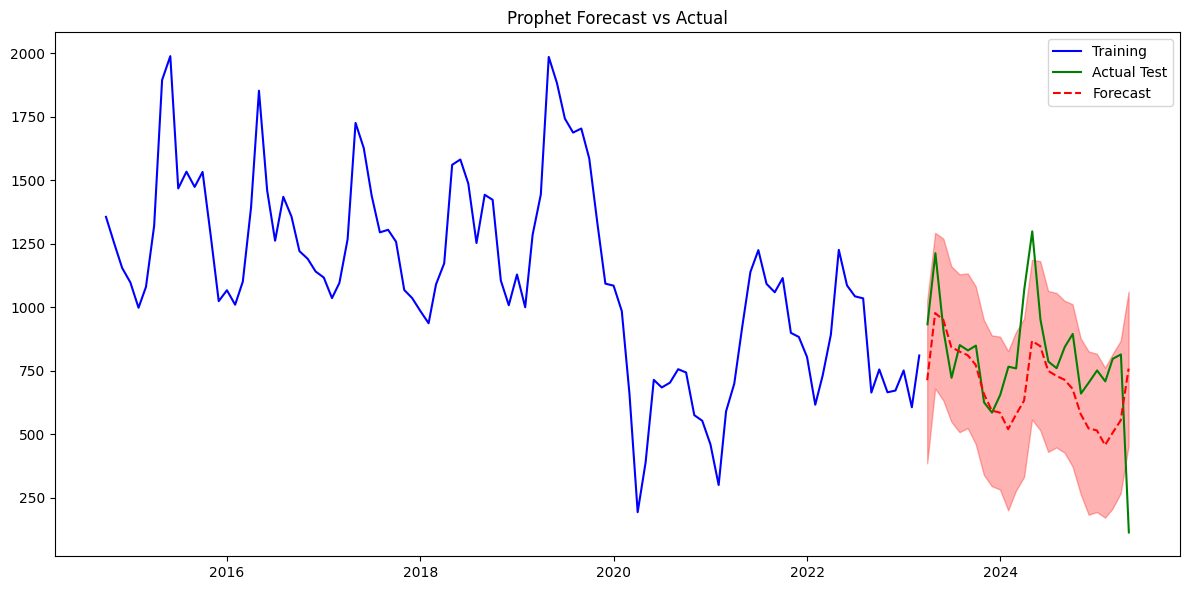

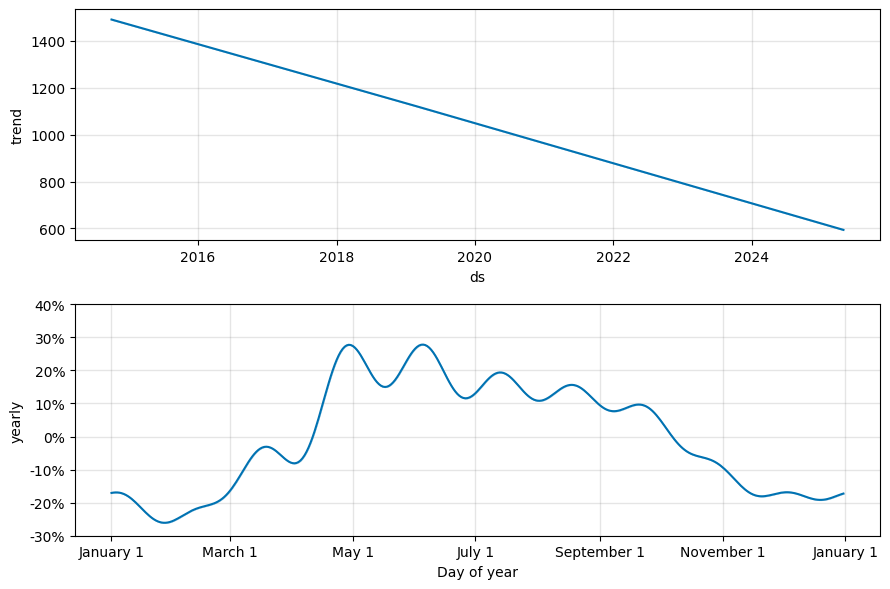

Stationarity Test: {'ADF_Statistic': np.float64(-1.0718022519179935), 'p_value': np.float64(0.7261848758574294), 'Critical_Values': {'1%': np.float64(-3.50434289821397), '5%': np.float64(-2.8938659630479413), '10%': np.float64(-2.5840147047458037)}, 'is_stationary': np.False_}
SARIMA Metrics:
MAE: 112.4541
MSE: 18472.2761
RMSE: 135.9128
R2: -0.5025
MAPE: 18.6795
AIC: 1169.2236
BIC: 1179.1329
Best SARIMA order: (0, 2, 2)
Best seasonal order: (0, 1, 1, 12)


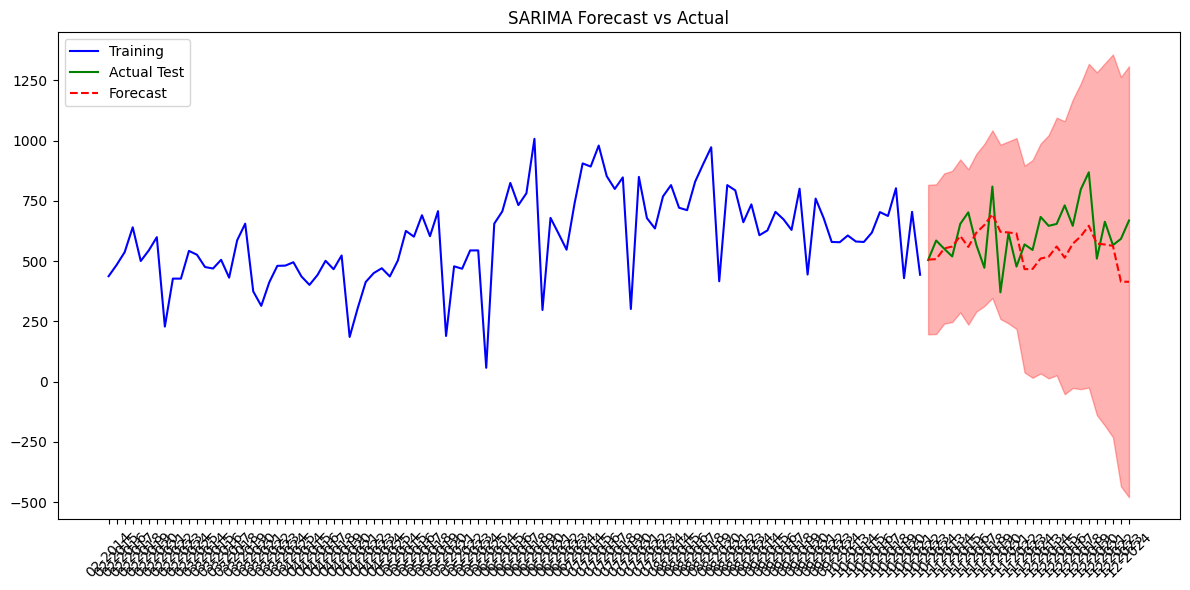

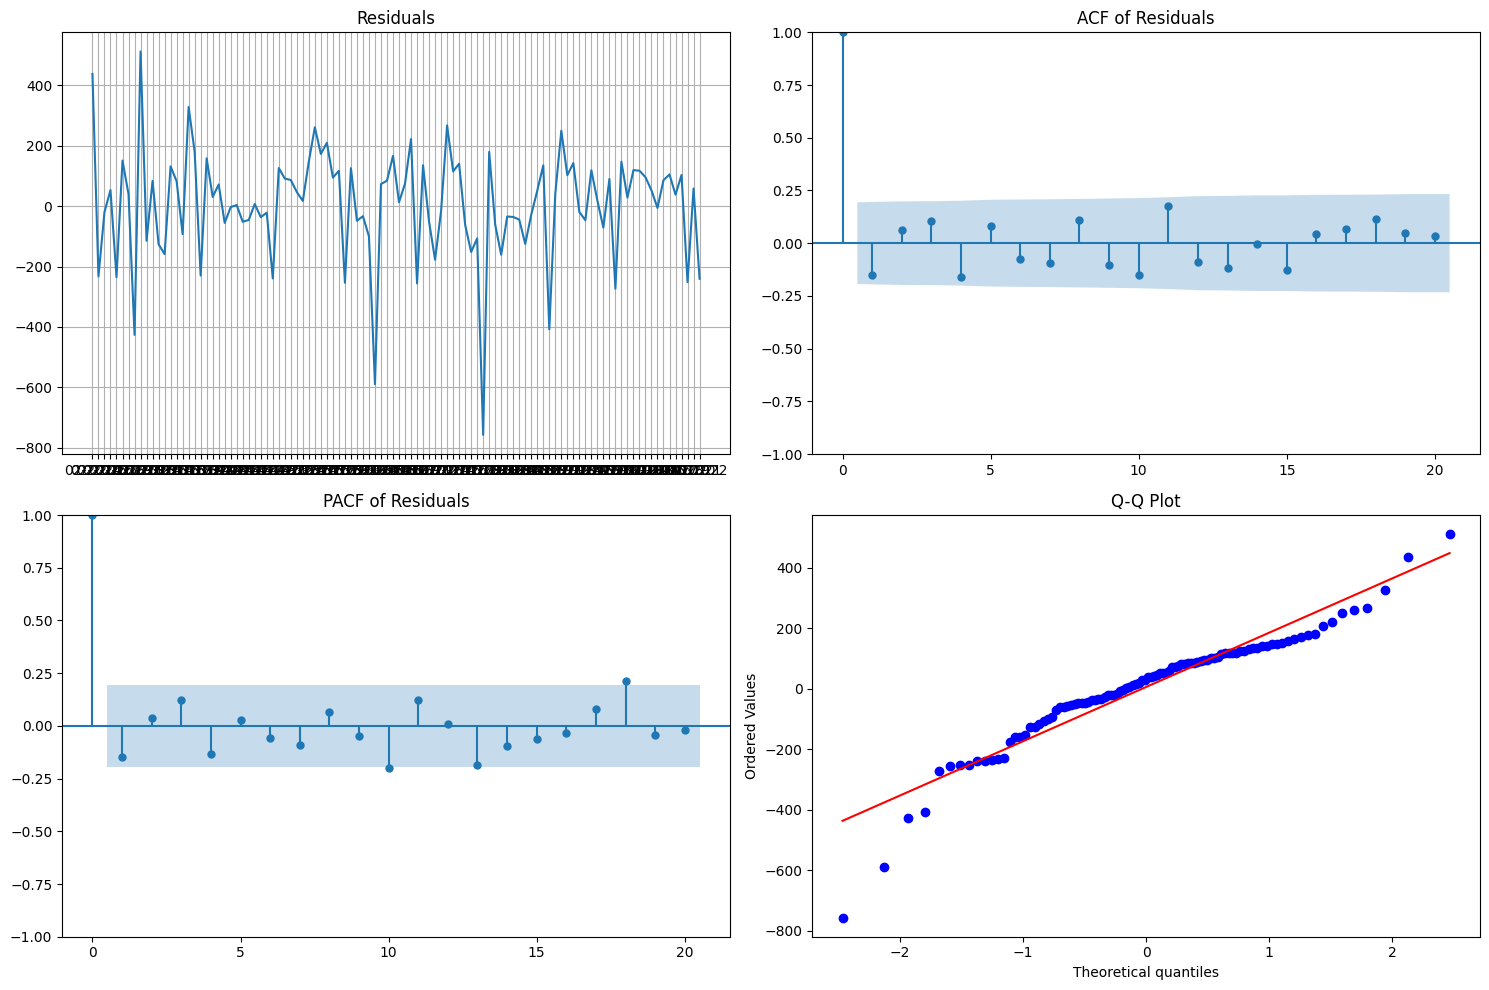

TypeError: '>' not supported between instances of 'str' and 'float'

In [65]:
# Prophet Evaluation
prophet_eval = ProphetEvaluator()
train_data, test_data = prophet_eval.prepare_data(df_intake_clean)
forecast = prophet_eval.fit_and_forecast()
prophet_metrics, prophet_pred = prophet_eval.evaluate()

print("Prophet Metrics:")
for metric, value in prophet_metrics.items():
    print(f"{metric}: {value:.4f}")

prophet_eval.plot_forecast()
prophet_eval.plot_components()

# SARIMA Evaluation  
sarima_eval = SARIMAEvaluator()
train_data, test_data = sarima_eval.prepare_data(df_outcome_clean)

# Check stationarity
stationarity = sarima_eval.check_stationarity(train_data)
print("Stationarity Test:", stationarity)

# Fit and forecast
forecast, conf_int = sarima_eval.fit_and_forecast()
sarima_metrics = sarima_eval.evaluate(forecast)

print("SARIMA Metrics:")
for metric, value in sarima_metrics.items():
    print(f"{metric}: {value:.4f}")

print(f"Best SARIMA order: {sarima_eval.best_order}")
print(f"Best seasonal order: {sarima_eval.best_seasonal}")

sarima_eval.plot_forecast(forecast, conf_int)
sarima_eval.diagnostic_plots()

# Ljung-Box test
lb_test = sarima_eval.ljung_box_test()
print("Ljung-Box Test:", lb_test)

# Final model: XGBoost

## Version 2

### Outcome predictor: XGBoost V2

In [81]:
class XGBoostOutcomeForecaster:
    def __init__(self):
        self.model = xgb.XGBRegressor(
            n_estimators=50,      # Reduced from 100
            max_depth=2,          # Reduced from 6  
            learning_rate=0.05,   # Reduced from 0.1
            reg_alpha=2.0,        # L1 regularization
            reg_lambda=2.0,       # L2 regularization
            random_state=42
        )
        self.feature_cols = None
        
    def prepare_data(self, df, target_col='count', test_size=0.2):
        # Sort by date to ensure chronological order
        df_sorted = df.sort_values('date').reset_index(drop=True)
        
        # Features (exclude target, date, year)
        exclude_cols = [target_col, 'date', 'year']
        self.feature_cols = [col for col in df_sorted.columns if col not in exclude_cols]
        
        X = df_sorted[self.feature_cols]
        y = df_sorted[target_col]
        
        # Time series split - chronological (last months as test)
        split_idx = int(len(df_sorted) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        return X_train, X_test, y_train, y_test
    
    def fit_and_evaluate(self, df, target_col='count'):
        X_train, X_test, y_train, y_test = self.prepare_data(df, target_col)
        
        # Fit model
        self.model.fit(X_train, y_train)
        
        # Predictions
        train_pred = self.model.predict(X_train)
        test_pred = self.model.predict(X_test)
        
        # Metrics
        metrics = {
            'Train_MAE': mean_absolute_error(y_train, train_pred),
            'Test_MAE': mean_absolute_error(y_test, test_pred),
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, test_pred)),
            'Train_R2': r2_score(y_train, train_pred),
            'Test_R2': r2_score(y_test, test_pred),
            'Train_MAPE': mean_absolute_percentage_error(y_train, train_pred),
            'Test_MAPE': mean_absolute_percentage_error(y_test, test_pred)
        }
        
        return metrics, test_pred, y_test
    
    def get_feature_importance(self):
        return pd.DataFrame({
            'feature': self.feature_cols,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
    
    def plot_results(self, test_pred, y_test, title="XGBoost Forecast"):
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Actual vs Predicted
        ax1.scatter(y_test, test_pred, alpha=0.6)
        ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        ax1.set_xlabel('Actual')
        ax1.set_ylabel('Predicted')
        ax1.set_title(f'{title} - Actual vs Predicted')
        
        # Time series plot
        ax2.plot(range(len(y_test)), y_test, 'b-', label='Actual', linewidth=2)
        ax2.plot(range(len(test_pred)), test_pred, 'r--', label='Predicted', linewidth=2)
        ax2.set_xlabel('Time Period')
        ax2.set_ylabel('Count')
        ax2.set_title(f'{title} - Time Series')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

### Intake predictor: XGBoost V2

In [82]:
class XGBoostIntakeForecaster:
    def __init__(self):
        self.model = xgb.XGBRegressor(
            n_estimators=50,      # Reduced from 100
            max_depth=3,          # Reduced from 6  
            learning_rate=0.05,   # Reduced from 0.1
            reg_alpha=1.0,        # L1 regularization
            reg_lambda=1.0,       # L2 regularization
            random_state=42
        )
        self.feature_cols = None
        
    def prepare_data(self, df, target_col='count', test_size=0.2):
        # Sort by date to ensure chronological order
        df_sorted = df.sort_values('date').reset_index(drop=True)
        
        # Features (exclude target, date, year)
        exclude_cols = [target_col, 'date', 'year']
        self.feature_cols = [col for col in df_sorted.columns if col not in exclude_cols]
        
        X = df_sorted[self.feature_cols]
        y = df_sorted[target_col]
        
        # Time series split - chronological (last months as test)
        split_idx = int(len(df_sorted) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        return X_train, X_test, y_train, y_test
    
    def fit_and_evaluate(self, df, target_col='count'):
        X_train, X_test, y_train, y_test = self.prepare_data(df, target_col)
        
        # Fit model
        self.model.fit(X_train, y_train)
        
        # Predictions
        train_pred = self.model.predict(X_train)
        test_pred = self.model.predict(X_test)
        
        # Metrics
        metrics = {
            'Train_MAE': mean_absolute_error(y_train, train_pred),
            'Test_MAE': mean_absolute_error(y_test, test_pred),
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, test_pred)),
            'Train_R2': r2_score(y_train, train_pred),
            'Test_R2': r2_score(y_test, test_pred),
            'Train_MAPE': mean_absolute_percentage_error(y_train, train_pred),
            'Test_MAPE': mean_absolute_percentage_error(y_test, test_pred)
        }
        
        return metrics, test_pred, y_test
    
    def get_feature_importance(self):
        return pd.DataFrame({
            'feature': self.feature_cols,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
    
    def plot_results(self, test_pred, y_test, title="XGBoost Forecast"):
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Actual vs Predicted
        ax1.scatter(y_test, test_pred, alpha=0.6)
        ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        ax1.set_xlabel('Actual')
        ax1.set_ylabel('Predicted')
        ax1.set_title(f'{title} - Actual vs Predicted')
        
        # Time series plot
        ax2.plot(range(len(y_test)), y_test, 'b-', label='Actual', linewidth=2)
        ax2.plot(range(len(test_pred)), test_pred, 'r--', label='Predicted', linewidth=2)
        ax2.set_xlabel('Time Period')
        ax2.set_ylabel('Count')
        ax2.set_title(f'{title} - Time Series')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

### XGBoost V2 model results

Intake XGBoost Metrics:
Train_MAE: 48.4431
Test_MAE: 114.8515
Train_RMSE: 64.8249
Test_RMSE: 156.0743
Train_R2: 0.9696
Test_R2: 0.4643
Train_MAPE: 0.0608
Test_MAPE: 0.2432

Top 5 Features:
                 feature  importance
11   count_rolling_max_3    0.555354
8   count_rolling_mean_3    0.158215
14   count_rolling_min_6    0.048024
17  count_rolling_std_12    0.032410
0                  month    0.030752


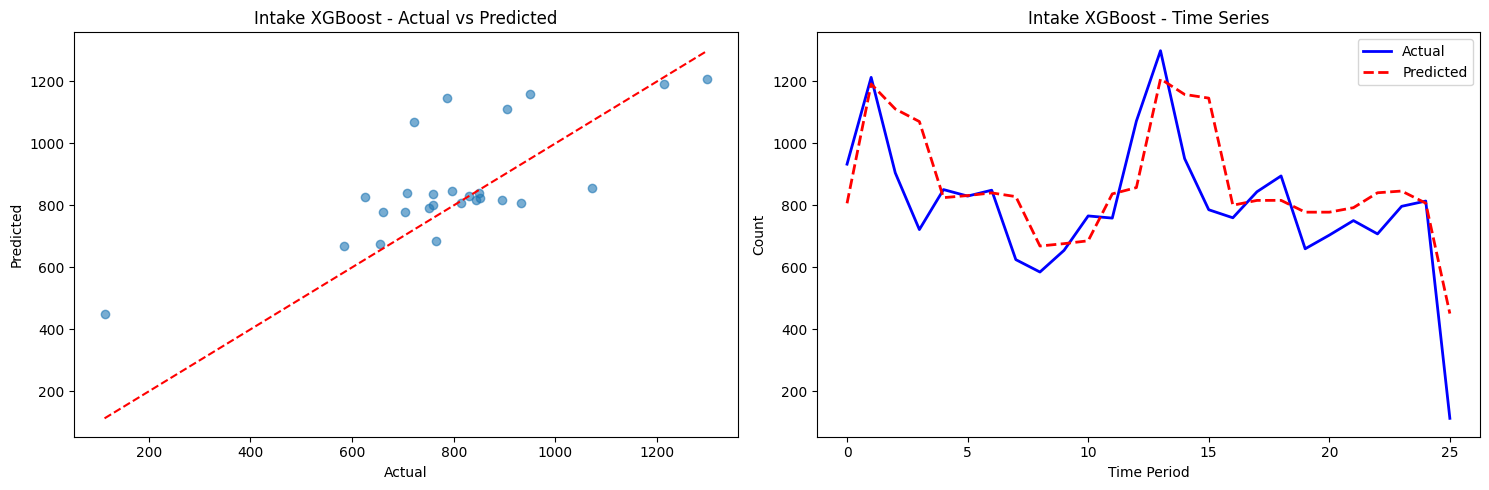


Outcome XGBoost Metrics:
Train_MAE: 53.4745
Test_MAE: 58.8790
Train_RMSE: 72.9664
Test_RMSE: 80.3300
Train_R2: 0.8386
Test_R2: 0.4751
Train_MAPE: 0.1473
Test_MAPE: 0.0988

Top 5 Features:
                  feature  importance
8    count_rolling_mean_3    0.254098
10    count_rolling_min_3    0.177898
0                   month    0.104164
16  count_rolling_mean_12    0.069261
11    count_rolling_max_3    0.064734


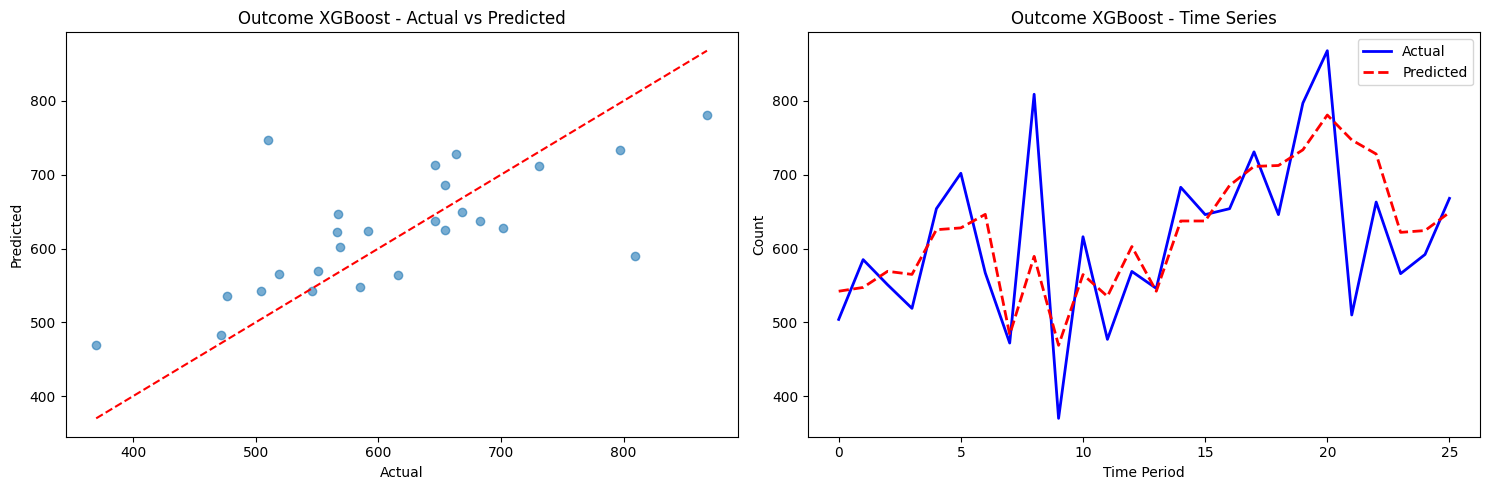

In [83]:
# Intake XGBoost
intake_xgb = XGBoostIntakeForecaster()
intake_metrics, intake_pred, intake_actual = intake_xgb.fit_and_evaluate(df_intake_clean, 'count')

print("Intake XGBoost Metrics:")
for k, v in intake_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nTop 5 Features:")
print(intake_xgb.get_feature_importance().head())

# Plot results
intake_xgb.plot_results(intake_pred, intake_actual, "Intake XGBoost")

# Outcome XGBoost
outcome_xgb = XGBoostOutcomeForecaster()
outcome_metrics, outcome_pred, outcome_actual = outcome_xgb.fit_and_evaluate(df_outcome_clean, 'count')

print("\nOutcome XGBoost Metrics:")
for k, v in outcome_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nTop 5 Features:")
print(outcome_xgb.get_feature_importance().head())

# Plot results
outcome_xgb.plot_results(outcome_pred, outcome_actual, "Outcome XGBoost")

## XGBoost V3